In [1]:
from pymongo import MongoClient
import time
import datetime
from pprint import pprint
import re
import numpy as np
from datetime import datetime as dtime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# %load SkyScanner_QueryAPI.py


# In[1]:

from pymongo import MongoClient
import time
import datetime
from pprint import pprint
import re


# In[2]:

def get_date(fmt, ts=None):
    ts = int(time.time()) if ts is None else int(ts)
    date = datetime.datetime.fromtimestamp(ts).strftime(fmt)
    return date

def parse_date(fmt, date):
    ts = time.mktime(datetime.datetime.strptime(date, fmt).timetuple())
    return ts


# In[3]:

class Agent(object):
    def __init__(self, data):
        self._name = data['Name']
        
    def name(self):
        return self._name
    
    def __str__(self):
        return self.name()

class Price(object):
    def __init__(self, itinerary, data):
        self.itinerary = itinerary
        self._price = data['Price']
        self._agents = data['Agents']
        
    def price(self):
        return self._price
    
    def agent(self):
        return [self.itinerary.flight.agent(id).name() for id in self._agents]
    
    def __str__(self):
        return "{}: {}€".format(self.agent(), self.price())

class Itinerary(object):
    def __init__(self, flight, data):
        self.flight = flight
        self.prices = [Price(self, p) for p in data['PricingOptions']]
        
    def cheapest(self):
        if not self.prices:
            return None
        
        return min(self.prices, key=lambda p: p.price())
        
    def most_expensive(self):
        if not self.prices:
            return None
        
        return max(self.prices, key=lambda p: p.price())

class Flight(object):
    def __init__(self, data):
        self.itineraries = [Itinerary(self, itinerary) for itinerary in data['Itineraries']]
        self.agents = {agent_data['Id']: Agent(agent_data) for agent_data in data['Agents']}
        self._id = data['_id']
        
    def cheapest(self):
        if not self.itineraries:
            return None
        
        return min(self.itineraries, key=lambda it: it.cheapest().price()).cheapest()
    
    def most_expensive(self):
        if not self.itineraries:
            return None
        
        return max(self.itineraries, key=lambda it: it.most_expensive().price()).most_expensive()
    
    def agent(self, id):
        return self.agents[id]
    
    def fake_date(self, dt):
        dt = get_date('%Y-%m-%d', dt)
        self._id['date'] = dt
    
    def date(self):
        return self._id['date']
    
    def date_timestamp(self):
        return parse_date('%Y-%m-%d', self._id['date'])
    
    def departure(self):
        return self._id['departure']
    
    def departure_timestamp(self):
        return parse_date('%Y-%m-%d', self._id['departure'])
    
    def __str__(self):
        return "{{{}->{}}} {} - {}".format(self.date(), self.departure(), self.cheapest(), self.most_expensive())
    
    def is_missing(self):
        return False
    
    
class MisingFlight(object):
    def __init__(self, date):
        self.ts = date
        self.dt = get_date('%Y-%m-%d', date)
        
    def date(self):
        return self.dt
    
    def date_timestamp(self):
        return self.ts
    
    def __str__(self):
        return "{{{}}} Missing".format(self.date())
    
    def is_missing(self):
        return True


# In[4]:

import math
from collections import OrderedDict

class SkyscannerAPI(object):
    def __init__(self, host='localhost'):
        self.client = MongoClient(host)
        self.db = self.client.skyscanner
        self.itineraries = self.db.itineraries
        self.carriers = self.db.carriers
        
    def find_flight(self, departure, destination,origin):
        cursor = self.itineraries.find({
            '_id.departure': departure,
            '_id.origin': origin,
            '_id.destination': destination            
        }, {
            '_id': 1,
            'Itineraries.PricingOptions': 1,
            'Agents.Id': 1,
            'Agents.Name': 1
        })
        
        def distribute(sorted_flights):
            i = 0
            total = len(sorted_flights) - 1
    
            dist = []
            while i < total:
                cur = i
                i += 1
                
                while i < total - 1 and sorted_flights[cur].date() == sorted_flights[i].date():
                    i += 1
                    
                diff_in_days = sorted_flights[i].date_timestamp() - sorted_flights[cur].date_timestamp()
                diff_in_days = math.ceil(diff_in_days / (24 * 60 * 60)) - 1
                
                dist.append(sorted_flights[cur])
                
                ts = parse_date('%Y-%m-%d', sorted_flights[cur].date())
                    
                for k in range(int(min(diff_in_days, i - cur))):
                    sorted_flights[cur + k].fake_date(ts + (k + 1) * 24 * 60 * 60)
                    dist.append(sorted_flights[cur + k])
                    
                for k in range(int(diff_in_days - (i - cur))):
                    dist.append(MisingFlight(ts + (k + (i - cur) + 1) * 24 * 60 * 60))
                    
            return dist
        
        sorted_flights = sorted([Flight(data) for data in cursor], key=lambda f: f.date_timestamp())
        sorted_flights = [f for f in sorted_flights if f.cheapest()]
        dist_flights = distribute(sorted_flights)
        unique_flights = OrderedDict([(f.date(), f) for f in dist_flights])
        return list(unique_flights.values())



In [6]:
api = SkyscannerAPI()

In [7]:
Airport = ['LCY', 'LHR', 'LGW', 'LTN', 'SEN', 'STN','CDG', 'ORY', 'BVA','MAD','ATH','FCO','CIA','BRU', 'CRL',
          'BER', 'SXF','DME', 'SVO','SFO','JFK','PEK','EZE','GIG','DEL']

In [10]:
Oil_prices = pd.read_csv('/home/manuel/Documentos/Master UB/TFM/TFM---Travel-chat-bot/DCOILBRENTEU.csv')
Oil_prices.DCOILBRENTEU[Oil_prices.DCOILBRENTEU == '.'] = float('nan')
Dates = [(dtime.today().date() - datetime.timedelta(days=x)).isoformat() for x in range(0, 365)]
Dates = pd.DataFrame({'DATE': Dates})

Oil_prices = Oil_prices.merge(Dates,how = 'right').sort_values('DATE').fillna(method = 'ffill')

In [11]:
init = dtime.strptime('2017-06-30', '%Y-%m-%d')
#flights = []
x = []
x2 = []
y = []
for air in Airport:
    print air
    flightsairport = []
    for i in range(90):
        date = init + datetime.timedelta(days=i)
        flightsaux = api.find_flight(date.strftime("%Y-%m-%d"), air, 'BCN')
        #flights = np.r_[flights,flightsaux]
        flightsairport = np.r_[flightsairport,flightsaux]
    for f in flightsairport:
        if type(f) is MisingFlight:
            continue
        x.append([(dtime.strptime(f.departure(), '%Y-%m-%d')-dtime.strptime(f.date(), '%Y-%m-%d')).days,
              float(Oil_prices.DCOILBRENTEU[Oil_prices.DATE == f.date()].values[0])])
        x2.append([Airport.index(air),
                  dtime.strptime(f.date(), '%Y-%m-%d').weekday(),
                  dtime.strptime(f.departure(), '%Y-%m-%d').weekday(),
                  dtime.strptime(f.departure(), '%Y-%m-%d').month])
        y.append(f.cheapest().price())
        
    %reset_selective -f flightsairport
    %reset_selective -f flightsaux

LCY
LHR
LGW
LTN
SEN
STN
CDG
ORY
BVA
MAD
ATH
FCO
CIA
BRU
CRL
BER
SXF
DME
SVO
SFO
JFK
PEK
EZE
GIG
DEL


In [2]:
import cPickle

#with open(r"x.pickle", "wb") as output_file:
#    cPickle.dump(x, output_file)
#with open(r"x2.pickle", "wb") as output_file:
#    cPickle.dump(x2, output_file)
#with open(r"y.pickle", "wb") as output_file:
#    cPickle.dump(y, output_file)
    
with open(r"x.pickle", "rb") as input_file:
    x = cPickle.load(input_file)
with open(r"x2.pickle", "rb") as input_file:
    x2 = cPickle.load(input_file)
with open(r"y.pickle", "rb") as input_file:
    y = cPickle.load(input_file)

Destinations
'LCY', 'LHR', 'LGW', 'LTN', 'SEN', 'STN', # LONDRES
'CDG', 'ORY', 'BVA', # Paris
'MAD', # Madrid
'ATH', # Atenas
'FCO', 'CIA', # Rome
'BRU', 'CRL', # Bruselas
'BER', 'SXF', # Berlin
'DME', 'SVO', # Moscu
'SFO', # San Francisco
'JFK', # Nueva York
'PEK', # Pekin
'EZE', # Buenos Aires
'GIG', # Rio de Janeiro
'DEL', # Delhi

Price according to the number of days that the flight is bought before departure

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
to_encode = []
for i in range(25):
    for j in range(7):
        for k in range(7):
            for l in range(12):
                to_encode.append([i,j,k,l+1])
        

enc = OneHotEncoder()
enc.fit(to_encode)  
enc.feature_indices_

array([ 0, 25, 32, 39, 52])

In [11]:
x3 = np.array(np.c_[x,enc.transform(x2).toarray().tolist(),y])
np.random.shuffle(x3)

In [19]:
X = {'LCY':np.array([l[0:(len(l)-1)] for l in x3 if l[2] == 1]),'LHR':np.array([l[0:(len(l)-1)] for l in x3 if l[3] == 1]),
     'LGW':np.array([l[0:(len(l)-1)] for l in x3 if l[4] == 1]),'LTN':np.array([l[0:(len(l)-1)] for l in x3 if l[5] == 1]),
     'SEN':np.array([l[0:(len(l)-1)] for l in x3 if l[6] == 1]),'STN':np.array([l[0:(len(l)-1)] for l in x3 if l[7] == 1]),
     'CDG':np.array([l[0:(len(l)-1)] for l in x3 if l[8] == 1]),'ORY':np.array([l[0:(len(l)-1)] for l in x3 if l[9] == 1]),
     'BVA':np.array([l[0:(len(l)-1)] for l in x3 if l[10] == 1]),'MAD':np.array([l[0:(len(l)-1)] for l in x3 if l[11] == 1]),
     'ATH':np.array([l[0:(len(l)-1)] for l in x3 if l[12] == 1]),'FCO':np.array([l[0:(len(l)-1)] for l in x3 if l[13] == 1]),
     'CIA':np.array([l[0:(len(l)-1)] for l in x3 if l[14] == 1]),'BRU':np.array([l[0:(len(l)-1)] for l in x3 if l[15] == 1]),
     'CRL':np.array([l[0:(len(l)-1)] for l in x3 if l[16] == 1]),'BER':np.array([l[0:(len(l)-1)] for l in x3 if l[17] == 1]),
     'SXF':np.array([l[0:(len(l)-1)] for l in x3 if l[18] == 1]),'DME':np.array([l[0:(len(l)-1)] for l in x3 if l[19] == 1]),
     'SVO':np.array([l[0:(len(l)-1)] for l in x3 if l[20] == 1]),'SFO':np.array([l[0:(len(l)-1)] for l in x3 if l[21] == 1]),
     'JFK':np.array([l[0:(len(l)-1)] for l in x3 if l[22] == 1]),'PEK':np.array([l[0:(len(l)-1)] for l in x3 if l[23] == 1]),
     'EZE':np.array([l[0:(len(l)-1)] for l in x3 if l[24] == 1]),'GIG':np.array([l[0:(len(l)-1)] for l in x3 if l[25] == 1]),
     'DEL':np.array([l[0:(len(l)-1)] for l in x3 if l[26] == 1])}
Y = {'LCY':np.array([l[len(l)-1] for l in x3 if l[2] == 1]),'LHR':np.array([l[len(l)-1] for l in x3 if l[3] == 1]),
     'LGW':np.array([l[len(l)-1] for l in x3 if l[4] == 1]),'LTN':np.array([l[len(l)-1] for l in x3 if l[5] == 1]),
     'SEN':np.array([l[len(l)-1] for l in x3 if l[6] == 1]),'STN':np.array([l[len(l)-1] for l in x3 if l[7] == 1]),
     'CDG':np.array([l[len(l)-1] for l in x3 if l[8] == 1]),'ORY':np.array([l[len(l)-1] for l in x3 if l[9] == 1]),
     'BVA':np.array([l[len(l)-1] for l in x3 if l[10] == 1]),'MAD':np.array([l[len(l)-1] for l in x3 if l[11] == 1]),
     'ATH':np.array([l[len(l)-1] for l in x3 if l[12] == 1]),'FCO':np.array([l[len(l)-1] for l in x3 if l[13] == 1]),
     'CIA':np.array([l[len(l)-1] for l in x3 if l[14] == 1]),'BRU':np.array([l[len(l)-1] for l in x3 if l[15] == 1]),
     'CRL':np.array([l[len(l)-1] for l in x3 if l[16] == 1]),'BER':np.array([l[len(l)-1] for l in x3 if l[17] == 1]),
     'SXF':np.array([l[len(l)-1] for l in x3 if l[18] == 1]),'DME':np.array([l[len(l)-1] for l in x3 if l[19] == 1]),
     'SVO':np.array([l[len(l)-1] for l in x3 if l[20] == 1]),'SFO':np.array([l[len(l)-1] for l in x3 if l[21] == 1]),
     'JFK':np.array([l[len(l)-1] for l in x3 if l[22] == 1]),'PEK':np.array([l[len(l)-1] for l in x3 if l[23] == 1]),
     'EZE':np.array([l[len(l)-1] for l in x3 if l[24] == 1]),'GIG':np.array([l[len(l)-1] for l in x3 if l[25] == 1]),
     'DEL':np.array([l[len(l)-1] for l in x3 if l[26] == 1])}

In [20]:
Rfregressor = {'LCY':[], 'LHR':[], 'LGW':[], 'LTN':[], 'SEN':[], 'STN':[],'CDG':[], 'ORY':[], 'BVA':[],'MAD':[],'ATH':[],'FCO':[],'CIA':[],'BRU':[], 'CRL':[],
          'BER':[], 'SXF':[],'DME':[], 'SVO':[],'SFO':[],'JFK':[],'PEK':[],'EZE':[],'GIG':[],'DEL':[]}

In [22]:
from sklearn import metrics
from sklearn import cross_validation
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler



In [23]:
nfolds = 5
for air in Airport:
    X_air = X[air]
    Y_air = Y[air]
    kf = cross_validation.KFold(n=X_air.shape[0], n_folds=nfolds, shuffle=False, random_state=0)
    
    yhat = np.empty(Y_air.shape[0])
    acc = np.empty(nfolds)
    yhat_train = np.empty(Y_air.shape[0])
    acc_train = np.empty(nfolds)
    i = 0
    for train_index, test_index in kf:

        X_train_air, X_test_air = X_air[train_index], X_air[test_index]
        y_train_air, y_test_air = Y_air[train_index], Y_air[test_index]

        # scale?
        #scaler = StandardScaler()
        #X_train_air = scaler.fit_transform(X_train_air)

        # Regressor
        #Rfregressor_air = Lasso()
        #Rfregressor_air = ElasticNet()
        #Rfregressor_air = Ridge()
        Rfregressor_air = RandomForestRegressor(n_estimators=100)
        #Rfregressor_air = SVR(kernel = 'linear')
        #Rfregressor_air = SVR(kernel = 'rbf')
        
        Rfregressor_air.fit(X_train_air,y_train_air)
        
        #X_test_air = scaler.transform(X_test_air)
        yhat[test_index] = Rfregressor_air.predict(X_test_air)
        acc[i] = metrics.mean_absolute_error(yhat[test_index], y_test_air)

        yhat_train[train_index] = Rfregressor_air.predict(X_train_air)
        acc_train[i] = metrics.mean_absolute_error(yhat_train[train_index], y_train_air)


        i +=1
    Rfregressor_air = RandomForestRegressor(n_estimators=100)
    Rfregressor_air.fit(X_air,Y_air)
    Rfregressor[air] = Rfregressor_air
    print air
    print 'Mean accuracy: '+ str(np.mean(acc)) + '  ' +str(np.mean(acc_train))
    #print 'Mean accuracy train: '+ str(np.mean(acc_train))

LCY
Mean accuracy: 12.4272842407  5.0915435197
LHR
Mean accuracy: 9.26709837468  3.81025767214
LGW
Mean accuracy: 8.47425144144  3.45925930045
LTN
Mean accuracy: 7.85431530628  3.26224588382
SEN
Mean accuracy: 22.0703618381  8.58588542242
STN
Mean accuracy: 40.9283554389  16.5840124251
CDG
Mean accuracy: 9.07891114705  3.70517309699
ORY
Mean accuracy: 8.41635281488  3.41018863188
BVA
Mean accuracy: 61.3084047575  23.3691115321
MAD
Mean accuracy: 6.48179820481  2.6431813076
ATH
Mean accuracy: 13.4077024797  5.44504065181
FCO
Mean accuracy: 10.3569536998  4.19292308211
CIA
Mean accuracy: 13.9934665274  5.3849291454
BRU
Mean accuracy: 10.5774432891  4.26594765181
CRL
Mean accuracy: 93.8999536995  37.6073808017
BER
Mean accuracy: 9.41000055619  3.82084065845
SXF
Mean accuracy: 12.7643767586  5.16942234753
DME
Mean accuracy: 29.9828920944  10.5201208946
SVO
Mean accuracy: 12.6710845381  5.16410690531
SFO
Mean accuracy: 72.2524601465  28.1835560739
JFK
Mean accuracy: 29.1649311843  11.813112

In [24]:
with open(r"Rfregressor.pickle", "wb") as output_file:
    cPickle.dump(Rfregressor, output_file)
    
#with open(r"Rfregressor.pickle", "rb") as input_file:
#    Rfregressor = cPickle.load(input_file)

In [ ]:
import numpy as np
from datetime import datetime as dtime
import pandas as pd
import datetime
import cPickle
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import OneHotEncoder

Oil_prices = pd.read_csv('/home/manuel/Documentos/Master UB/TFM/TFM---Travel-chat-bot/DCOILBRENTEU.csv')
Oil_prices.DCOILBRENTEU[Oil_prices.DCOILBRENTEU == '.'] = float('nan')
Dates = [(dtime.today().date() - datetime.timedelta(days=x)).isoformat() for x in range(0, 365)]
Dates = pd.DataFrame({'DATE': Dates})
Oil_prices = Oil_prices.merge(Dates,how = 'right').sort_values('DATE').fillna(method = 'ffill')

with open(r"Rfregressor.pickle", "rb") as input_file:
    Rfregressor = cPickle.load(input_file)
    
Airport = ['LCY', 'LHR', 'LGW', 'LTN', 'SEN', 'STN','CDG', 'ORY', 'BVA','MAD','ATH','FCO','CIA','BRU', 'CRL',
          'BER', 'SXF','DME', 'SVO','SFO','JFK','PEK','EZE','GIG','DEL']
Airport_array = np.array(Airport)
Airport_cities = ['london','london','london','london','london','london','paris','paris','paris','madrid','athens','rome','rome',
                 'brussels','brussels','berlin','berlin','moscow','moscow','san francisco','new york','beijing','buenos aires',
                 'rio de janeiro','new delhi']
to_encode = []
for i in range(25):
    for j in range(7):
        for k in range(7):
            for l in range(12):
                to_encode.append([i,j,k,l+1])
enc = OneHotEncoder()
enc.fit(to_encode)  


def PredictLowestPrice(departure_date,origin,destination):
    Rfregressor_air = Rfregressor[origin]
    today = dtime.today().date()
    departure_date = dtime.strptime(departure_date, '%Y-%m-%d').date()
    predict2 = []
    predict = []
    date = today
    for i in range((departure_date-today).days):
        date = today + datetime.timedelta(days=i)
        predict2.append([Airport.index(origin),
                  date.weekday(),
                  departure_date.weekday(),
                  departure_date.month])
        predict.append([(departure_date-date).days,
                      float(Oil_prices[Oil_prices.DATE == today.isoformat()].DCOILBRENTEU.values[0])])
    predict3 = np.c_[predict,enc.transform(predict2).toarray().tolist()]
    prediction = Rfregressor_air.predict(predict3)
    #return today, prediction[0],destination
    days_wait_to_buy = [k1  for k1, k2 in enumerate(prediction) if k2 == min(prediction) ][0]
    price = min(prediction)
    return (today + datetime.timedelta(days=days_wait_to_buy) ).isoformat(), price, origin,destination


def FindBestFlight(departure_date,origin,destination):
    if destination.lower() != 'barcelona' and destination != 'BCN':
        return 0,0,0
    if origin in Airport:
        day,price,origin,destination = PredictLowestPrice(departure_date,origin,'BCN')
        return day,price,origin,destination
    else:
        ori = origin.lower()
        if ori in Airport_cities:
            airs = Airport_array[[k for k,city in enumerate(Airport_cities) if city == ori]] 
            minprice = 1e10
            for air in airs:
                day,price,origin,destination = PredictLowestPrice(departure_date,air,'BCN')
                if price < minprice:
                    minprice = price
                    minday = day
                    minairport = origin
            return minday,minprice,minairport,destination
        else:
            return 0,0,0

In [26]:
FindBestFlight('2017-08-04','london','barcelona')

('2017-07-04', 49.688199999999888, 'LTN', 'BCN')

In [6]:
air = 1 # athens

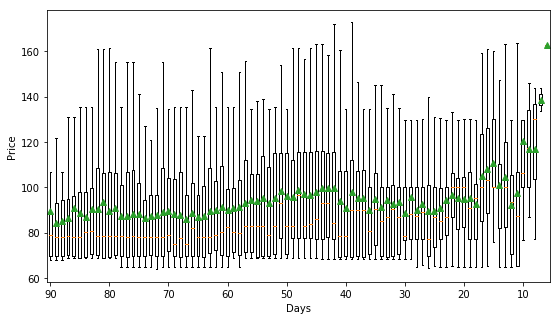

In [7]:
# antelacion
x4 = np.array(np.c_[x,x2,y])
f4 = [[t[0],t[6]] for t in x4 if (t[2] == air and t[5]<8 and t[5]>6) ]

values = sorted(set(map(lambda j:-j[0], f4)))
newlist = [[j[1] for j in f4 if j[0]==-i] for i in values]

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(9, 5))
ax = fig.add_subplot(111)
bp = ax.boxplot(newlist,labels = values, showmeans=True,showfliers=False)
plt.xticks([1, 11,21,31,41,51,61,71,81], ['90','80','70','60','50','40','30','20','10'])
ax.set_xlabel('Days')
ax.set_ylabel('Price')
#plt.legend(('mean','median'),numpoints = 1)
#leg = ax.get_legend()
#leg.legendHandles[0].set_color('green')
#leg.legendHandles[0].set_marker('^')
#leg.legendHandles[0].set_linestyle('None')
#leg.legendHandles[1].set_color('orange')
fig.savefig("daysbeforelondon.png", bbox_inches='tight')

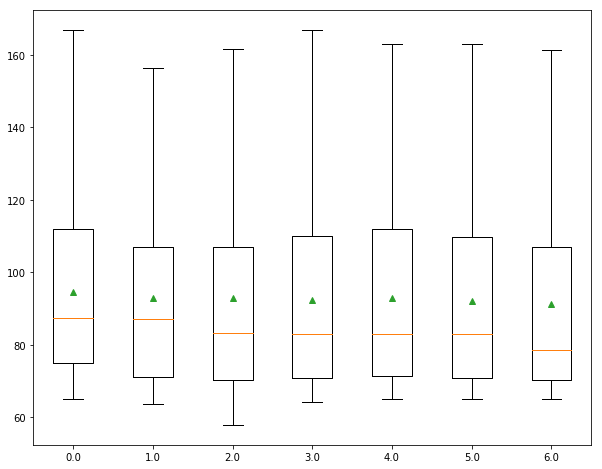

In [7]:
# dia de compra

x4 = np.array(np.c_[x,x2,y])
f4 = [[t[3],t[6]] for t in x4 if t[2] == air]

values = sorted(set(map(lambda j:j[0], f4)))
newlist = [[j[1] for j in f4 if j[0]==i] for i in values]

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(10, 8))
ax = fig.add_subplot(111)
bp = ax.boxplot(newlist, showmeans=True,labels = values,showfliers=False)


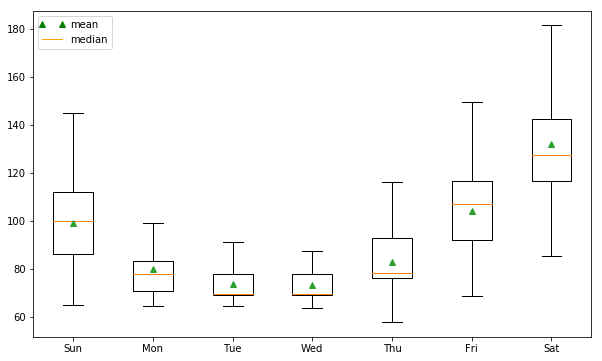

In [8]:
# dia de llegada

x4 = np.array(np.c_[x,x2,y])
f4 = [[t[4],t[6]] for t in x4 if t[2] == air]

values = sorted(set(map(lambda j:j[0], f4)))
newlist = [[j[1] for j in f4 if j[0]==i] for i in values]

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(10, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(newlist,labels = values, showmeans=True,showfliers=False)
plt.xticks([1, 2, 3,4,5,6,7], ['Sun','Mon', 'Tue', 'Wed','Thu','Fri','Sat'])
plt.legend(('mean','median'),numpoints = 1)
leg = ax.get_legend()
leg.legendHandles[0].set_color('green')
leg.legendHandles[0].set_marker('^')
leg.legendHandles[0].set_linestyle('None')
leg.legendHandles[1].set_color('orange')
fig.savefig("days.png")

In [188]:
a = leg.legendHandles[0]
a.set_

1

In [63]:
[np.mean(i) for i in newlist]


[161.35561224489797,
 133.22705673758864,
 133.40298181818184,
 123.45760299625468,
 178.54529780564263,
 163.77279742765273,
 161.65033112582785]